#**스마트폰 센서 데이터 기반 모션 분류**
# 단계2 : 기본 모델링


## 0.미션

* 데이터 전처리
    * 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리 수행
* 다양한 알고리즘으로 분류 모델 생성
    * 최소 4개 이상의 알고리즘을 적용하여 모델링 수행 
    * 성능 비교
    * 각 모델의 성능을 저장하는 별도 데이터 프레임을 만들고 비교
* 옵션 : 다음 사항은 선택사항입니다. 시간이 허용하는 범위 내에서 수행하세요.
    * 상위 N개 변수를 선정하여 모델링 및 성능 비교
        * 모델링에 항상 모든 변수가 필요한 것은 아닙니다.
        * 변수 중요도 상위 N개를 선정하여 모델링하고 타 모델과 성능을 비교하세요.
        * 상위 N개를 선택하는 방법은, 변수를 하나씩 늘려가며 모델링 및 성능 검증을 수행하여 적절한 지점을 찾는 것입니다.

## 1.환경설정

### (1) 라이브러리 불러오기

* 세부 요구사항
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.

In [97]:
#pip install tensorflow

In [98]:
#pip install keras

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 필요하다고 판단되는 라이브러리를 추가하세요.
from sklearn.metrics import *
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.backend import clear_session
from keras.optimizers import Adam

* 함수 생성

In [ ]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

In [3]:
def feature_importances(importance,feature_name):
    df=pd.DataFrame()
    df['importance'] = importance
    df['feature_name'] = feature_name
    df.sort_values('importance',ascending=False,inplace=True)
    df.reset_index(drop=True,inplace=True)
    sns.barplot(x='importance',y='feature_name',data=df.head())
    plt.xlabel('importance')
    plt.ylabel('feature_name')
    plt.show()
    
    return df

### (2) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
* 세부 요구사항
    - 전체 데이터 'data01_train.csv' 를 불러와 'data' 이름으로 저장합니다.
        - data에서 변수 subject는 삭제합니다.
    - 데이터프레임에 대한 기본 정보를 확인합니다.( .head(), .shape 등)

#### 1) 데이터 로딩

In [141]:
data = pd.read_csv('data01_train.csv')

In [142]:
data.drop('subject',axis=1,inplace=True)

#### 2) 기본 정보 조회

In [143]:
data.shape

(5881, 562)

In [144]:
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


In [145]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
tBodyAcc-mean()-X,5881.0,0.274811,0.067614,-0.503823,0.262919,0.277154,0.288526,1.000000
tBodyAcc-mean()-Y,5881.0,-0.017799,0.039422,-0.684893,-0.024877,-0.017221,-0.010920,1.000000
tBodyAcc-mean()-Z,5881.0,-0.109396,0.058373,-1.000000,-0.121051,-0.108781,-0.098163,1.000000
tBodyAcc-std()-X,5881.0,-0.603138,0.448807,-1.000000,-0.992774,-0.943933,-0.242130,1.000000
tBodyAcc-std()-Y,5881.0,-0.509815,0.501815,-0.999844,-0.977680,-0.844575,-0.034499,0.916238
...,...,...,...,...,...,...,...,...
"angle(tBodyGyroMean,gravityMean)",5881.0,0.009340,0.608190,-1.000000,-0.481718,0.011448,0.499857,0.998702
"angle(tBodyGyroJerkMean,gravityMean)",5881.0,-0.007099,0.476738,-1.000000,-0.373345,-0.000847,0.356236,0.996078
"angle(X,gravityMean)",5881.0,-0.491501,0.509069,-1.000000,-0.811397,-0.709441,-0.511330,0.977344
"angle(Y,gravityMean)",5881.0,0.059299,0.297340,-1.000000,-0.018203,0.182893,0.248435,0.478157


## **2. 데이터 전처리**

* 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리를 수행한다. 


### (1) 데이터 분할1 : x, y

* 세부 요구사항
    - x, y로 분할합니다.

In [146]:
target = 'Activity'
x = data.drop(target,axis=1)
y = data.loc[:,target]

### (2) 스케일링(필요시)


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [147]:
scaler = MinMaxScaler()
x_s = scaler.fit_transform(x)

### (3) 데이터분할2 : train, validation

* 세부 요구사항
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

In [151]:
x_train,x_val,y_train,y_val = train_test_split(x,y,test_size=.2,random_state=1)
x_train_s,x_val_s,y_train_s,y_val_s = train_test_split(x_s,y,test_size=.2,random_state=1)

## **3. 기본 모델링**



* 세부 요구사항
    - 최소 4개 이상의 알고리즘을 적용하여 모델링을 수행한다. 
    - 각 알고리즘별로 전체 변수로 모델링, 상위 N개 변수를 선택하여 모델링을 수행하고 성능 비교를 한다.
    - (옵션) 알고리즘 중 1~2개에 대해서, 변수 중요도 상위 N개를 선정하여 모델링하고 타 모델과 성능을 비교.
        * 상위 N개를 선택하는 방법은, 변수를 하나씩 늘려가며 모델링 및 성능 검증을 수행하여 적절한 지점을 찾는 것이다.

### (1) 알고리즘1 : 

In [152]:
model1 = RandomForestClassifier(random_state=1)
model1.fit(x_train,y_train)
y_pred1 = model1.predict(x_val)

In [209]:
print(accuracy_score(y_val,y_pred1))
print(confusion_matrix(y_val,y_pred1))
print(classification_report(y_val,y_pred1))

0.9770603228547153
[[220   0   0   0   1   1]
 [  0 191   7   0   0   0]
 [  0   7 228   0   0   0]
 [  0   0   0 186   3   3]
 [  0   0   0   1 153   2]
 [  0   0   0   1   1 172]]
                    precision    recall  f1-score   support

            LAYING       1.00      0.99      1.00       222
           SITTING       0.96      0.96      0.96       198
          STANDING       0.97      0.97      0.97       235
           WALKING       0.99      0.97      0.98       192
WALKING_DOWNSTAIRS       0.97      0.98      0.97       156
  WALKING_UPSTAIRS       0.97      0.99      0.98       174

          accuracy                           0.98      1177
         macro avg       0.98      0.98      0.98      1177
      weighted avg       0.98      0.98      0.98      1177



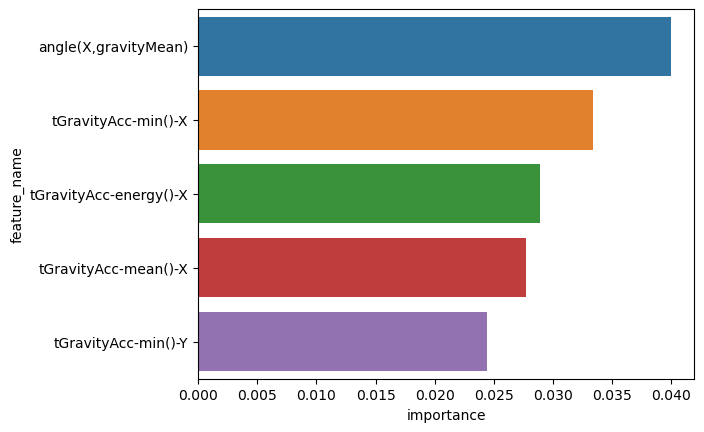

In [154]:
importance = model1.feature_importances_
feature_name = x_train.columns
df = feature_importances (importance,feature_name)

In [210]:
df.head()

,importance,feature_name
0,0.039760,"angle(X,gravityMean)"
1,0.034240,tGravityAcc-min()-X
2,0.029040,tGravityAcc-energy()-X
3,0.027413,tGravityAcc-mean()-X
4,0.023984,tGravityAcc-min()-Y


In [156]:
feature_100 = df.loc[:99,'feature_name']
feature_100.head()

0      angle(X,gravityMean)
1       tGravityAcc-min()-X
2    tGravityAcc-energy()-X
3      tGravityAcc-mean()-X
4       tGravityAcc-min()-Y
Name: feature_name, dtype: object

In [157]:
x_train_100 = x_train[feature_100]
x_val_100 = x_val[feature_100]

In [158]:
model1_2 = RandomForestClassifier(random_state=1)
model1_2.fit(x_train_100,y_train)
y_pred1_2 = model1_2.predict(x_val_100)

In [211]:
print(accuracy_score(y_val,y_pred1_2))
print(confusion_matrix(y_val,y_pred1_2))
print(classification_report(y_val,y_pred1_2))

0.9770603228547153
[[222   0   0   0   0   0]
 [  0 194   4   0   0   0]
 [  0  10 225   0   0   0]
 [  0   0   0 187   2   3]
 [  0   0   0   5 149   2]
 [  0   0   0   0   1 173]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       222
           SITTING       0.95      0.98      0.97       198
          STANDING       0.98      0.96      0.97       235
           WALKING       0.97      0.97      0.97       192
WALKING_DOWNSTAIRS       0.98      0.96      0.97       156
  WALKING_UPSTAIRS       0.97      0.99      0.98       174

          accuracy                           0.98      1177
         macro avg       0.98      0.98      0.98      1177
      weighted avg       0.98      0.98      0.98      1177



### (2) 알고리즘2 : 

In [160]:
model2=KNeighborsClassifier()
model2.fit(x_train_s,y_train_s)
y_pred2 = model2.predict(x_val_s)

In [161]:
print(confusion_matrix(y_val_s,y_pred2))
print(classification_report(y_val_s,y_pred2))

[[220   1   0   0   1   0]
 [  1 167  30   0   0   0]
 [  0  13 222   0   0   0]
 [  0   0   0 192   0   0]
 [  0   0   0   1 153   2]
 [  0   0   0   1   0 173]]
                    precision    recall  f1-score   support

            LAYING       1.00      0.99      0.99       222
           SITTING       0.92      0.84      0.88       198
          STANDING       0.88      0.94      0.91       235
           WALKING       0.99      1.00      0.99       192
WALKING_DOWNSTAIRS       0.99      0.98      0.99       156
  WALKING_UPSTAIRS       0.99      0.99      0.99       174

          accuracy                           0.96      1177
         macro avg       0.96      0.96      0.96      1177
      weighted avg       0.96      0.96      0.96      1177



### (3) 알고리즘3 : 

In [162]:
from sklearn.model_selection import GridSearchCV
model_RF = RandomForestClassifier(random_state=1) 
params={'max_depth':range(1,20)}
model3 = GridSearchCV(model_RF,
                     params,
                     cv=5,
                     scoring='accuracy')

In [163]:
model3.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1),
             param_grid={'max_depth': range(1, 20)}, scoring='accuracy')

In [164]:
print(model3.best_params_)
print(model3.best_score_)

{'max_depth': 17}
0.9738519456440636


In [165]:
y_pred3 = model3.predict(x_val)
print(confusion_matrix(y_val,y_pred3))
print(classification_report(y_val,y_pred3))

[[220   0   0   0   0   2]
 [  0 192   6   0   0   0]
 [  0   7 228   0   0   0]
 [  0   0   0 187   2   3]
 [  0   0   0   1 153   2]
 [  0   0   0   1   1 172]]
                    precision    recall  f1-score   support

            LAYING       1.00      0.99      1.00       222
           SITTING       0.96      0.97      0.97       198
          STANDING       0.97      0.97      0.97       235
           WALKING       0.99      0.97      0.98       192
WALKING_DOWNSTAIRS       0.98      0.98      0.98       156
  WALKING_UPSTAIRS       0.96      0.99      0.97       174

          accuracy                           0.98      1177
         macro avg       0.98      0.98      0.98      1177
      weighted avg       0.98      0.98      0.98      1177



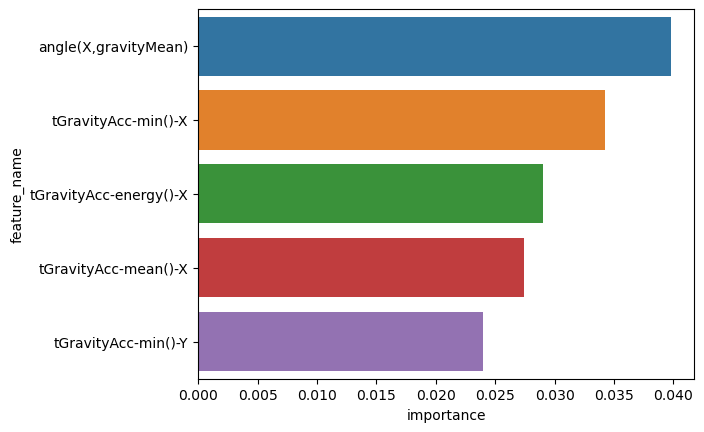

In [166]:
importance = model3.best_estimator_.feature_importances_
feature_name = x_train.columns
df = feature_importances(importance,feature_name)

In [168]:
feature_100 = df.loc[:99,'feature_name']

In [169]:
x_train_100 = x_train[feature_100]
x_val_100 = x_val[feature_100]

In [170]:
model_RF = RandomForestClassifier(random_state=1) 
params={'max_depth':range(1,20)}
model3_2 = GridSearchCV(model_RF,
                     params,
                     cv=5,
                     scoring='accuracy')

In [171]:
model3_2.fit(x_train_100,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1),
             param_grid={'max_depth': range(1, 20)}, scoring='accuracy')

In [172]:
y_pred3_2 = model3_2.predict(x_val_100)
print(confusion_matrix(y_val,y_pred3_2))
print(classification_report(y_val,y_pred3_2))

[[222   0   0   0   0   0]
 [  0 193   5   0   0   0]
 [  0   9 226   0   0   0]
 [  0   0   0 186   3   3]
 [  0   0   0   3 151   2]
 [  0   0   0   0   2 172]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       222
           SITTING       0.96      0.97      0.96       198
          STANDING       0.98      0.96      0.97       235
           WALKING       0.98      0.97      0.98       192
WALKING_DOWNSTAIRS       0.97      0.97      0.97       156
  WALKING_UPSTAIRS       0.97      0.99      0.98       174

          accuracy                           0.98      1177
         macro avg       0.98      0.98      0.98      1177
      weighted avg       0.98      0.98      0.98      1177



### (4) 알고리즘4 : 

In [173]:
model4 = LogisticRegression()

In [174]:
model4.fit(x_train,y_train)
y_pred4 = model4.predict(x_val)

C:\Users\User\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [175]:
print('accuracy:',accuracy_score(y_val,y_pred4))
print(confusion_matrix(y_val,y_pred4))
print(classification_report(y_val,y_pred4))

accuracy: 0.983857264231096
[[222   0   0   0   0   0]
 [  0 191   7   0   0   0]
 [  0  10 225   0   0   0]
 [  0   0   0 192   0   0]
 [  0   0   0   2 154   0]
 [  0   0   0   0   0 174]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       222
           SITTING       0.95      0.96      0.96       198
          STANDING       0.97      0.96      0.96       235
           WALKING       0.99      1.00      0.99       192
WALKING_DOWNSTAIRS       1.00      0.99      0.99       156
  WALKING_UPSTAIRS       1.00      1.00      1.00       174

          accuracy                           0.98      1177
         macro avg       0.98      0.98      0.98      1177
      weighted avg       0.98      0.98      0.98      1177



In [176]:
feature_100 = df.loc[:99,'feature_name']
x_train_100 = x_train[feature_100]
x_val_100 = x_val[feature_100]

In [177]:
model4_2 = LogisticRegression()
model4_2.fit(x_train_100,y_train)
y_pred4_2 = model4_2.predict(x_val_100)

C:\Users\User\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [178]:
print('accuracy:',accuracy_score(y_val,y_pred4_2))
print(confusion_matrix(y_val,y_pred4_2))
print(classification_report(y_val,y_pred4_2))

accuracy: 0.9643160577740016
[[222   0   0   0   0   0]
 [  0 180  18   0   0   0]
 [  0  17 218   0   0   0]
 [  0   0   0 188   0   4]
 [  0   0   0   1 153   2]
 [  0   0   0   0   0 174]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       222
           SITTING       0.91      0.91      0.91       198
          STANDING       0.92      0.93      0.93       235
           WALKING       0.99      0.98      0.99       192
WALKING_DOWNSTAIRS       1.00      0.98      0.99       156
  WALKING_UPSTAIRS       0.97      1.00      0.98       174

          accuracy                           0.96      1177
         macro avg       0.97      0.97      0.97      1177
      weighted avg       0.96      0.96      0.96      1177



### Deep

In [179]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err')
    plt.plot(history['val_loss'], label='val_err')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [189]:
data['Activity_map'] = data['Activity'].map({'LAYING':0, 'SITTING':1, 'STANDING':2, 'WALKING':3, 'WALKING_DOWNSTAIRS':4, 'WALKING_UPSTAIRS':5 } ) 

In [190]:
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,Activity_map
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING,2
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING,2
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING,3
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS,4


In [197]:
x= data.drop(['Activity','Activity_map'],axis=1)
y2= data.loc[:,'Activity_map']

In [198]:
x_train,x_val,y_train2,y_val2 = train_test_split(x,y2,test_size=.3,random_state=1)

In [199]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

In [200]:
nfeatures = x_train.shape[1]
nfeatures

561

In [201]:
clear_session()

model5 = Sequential([Dense(288,input_shape=(nfeatures,),activation='relu'),
                    Dense(144,activation='relu'),
                    Dense(72,activation='relu'),
                    Dense(36,activation='relu'),
                    Dense(6,activation='softmax')])

model5.summary()

C:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 288)                 │         161,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 144)                 │          41,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 72)                  │          10,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 36)                  │           2,628 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 6)                   │             222 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 216,762 (846.73 KB)

 Trainable params: 216,762 (846.73 KB)

 Non-trainable params: 0 (0.00 B)

In [202]:
model5.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy')

history = model5.fit(x_train, y_train2, epochs = 50, validation_split=0.2).history

Epoch 1/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1.0158 - val_loss: 0.3422
Epoch 2/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2948 - val_loss: 0.1710
Epoch 3/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2167 - val_loss: 0.1389
Epoch 4/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2171 - val_loss: 0.1063
Epoch 5/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1480 - val_loss: 0.1002
Epoch 6/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1231 - val_loss: 0.0880
Epoch 7/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1172 - val_loss: 0.2545
Epoch 8/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1278 - val_loss: 0.0770
Epoch 9/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0872 - val_loss: 0.0887
Epoch 10/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0944 - val_loss: 0.1657
Epoch 11/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1001 - val_loss: 0.0637
Epoch 12/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/ste

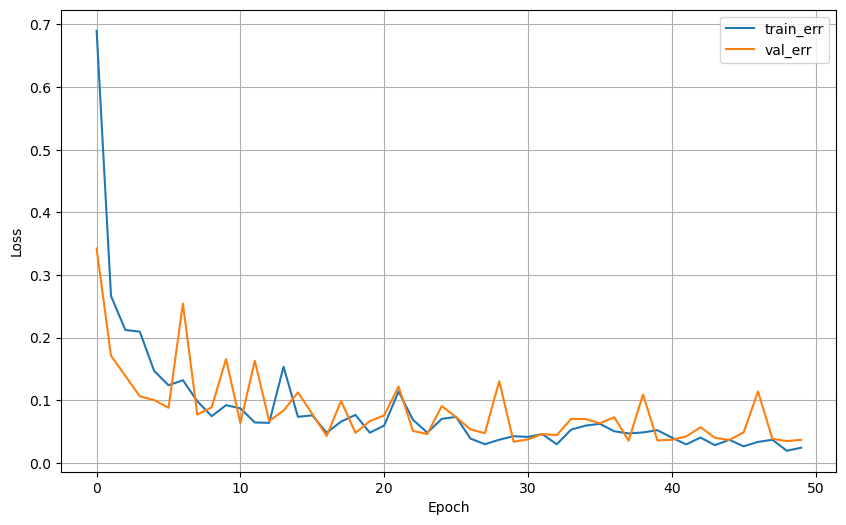

In [203]:
dl_history_plot(history)

In [204]:
y_pred5 = model5.predict(x_val)

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [205]:
y_pred5 = np.argmax(y_pred5,axis=1)

In [206]:
print(accuracy_score(y_val2, y_pred5))
print(confusion_matrix(y_val2, y_pred5))
print(classification_report(y_val2, y_pred5))

0.9835694050991501
[[331   0   0   0   0   0]
 [  1 272  19   0   0   0]
 [  0   6 325   0   0   0]
 [  0   0   0 296   1   0]
 [  0   0   0   0 237   2]
 [  0   0   0   0   0 275]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       331
           1       0.98      0.93      0.95       292
           2       0.94      0.98      0.96       331
           3       1.00      1.00      1.00       297
           4       1.00      0.99      0.99       239
           5       0.99      1.00      1.00       275

    accuracy                           0.98      1765
   macro avg       0.98      0.98      0.98      1765
weighted avg       0.98      0.98      0.98      1765



In [208]:
model_no = ['model1','model1_2', 'model2',\
            'model3', 'model3_2', 'model4', 'model4_2','model5']
algorithm = ['rf','rf', 'knn', 'rf_g', 'rf_g', 'lg', 'lg', 'dl']
pred = [y_pred1, y_pred1_2, y_pred2, y_pred3, y_pred3_2, y_pred4, y_pred4_2, y_pred5]
y_vals = [y_val, y_val, y_val_s, y_val, y_val, y_val, y_val, y_val2]

result = pd.DataFrame(columns=['model_no', 'algorithm', 'accuracy', 'f1_0', 'f1_1', 'f1_2', 'f1_3', 'f1_4', 'f1_5'])

for i in range(len(model_no)):
    f1 = list(f1_score(y_vals[i], pred[i], average=None))
    acc = accuracy_score(y_vals[i], pred[i])
    row = [model_no[i], algorithm[i], acc] + f1
    result.loc[i] = row

result

,model_no,algorithm,accuracy,f1_0,f1_1,f1_2,f1_3,f1_4,f1_5
0,model1,rf,0.977060,0.995475,0.964646,0.970213,0.978947,0.974522,0.977273
1,model1_2,rf,0.977060,1.000000,0.965174,0.969828,0.973958,0.967532,0.982955
2,model2,knn,0.957519,0.993228,0.881266,0.911704,0.994819,0.987097,0.991404
3,model3,rf_g,0.978760,0.995475,0.967254,0.972281,0.981627,0.980769,0.974504
4,model3_2,rf_g,0.977060,1.000000,0.965000,0.969957,0.976378,0.967949,0.980057
5,model4,lg,0.983857,1.000000,0.957393,0.963597,0.994819,0.993548,1.000000
6,model4_2,lg,0.964316,1.000000,0.911392,0.925690,0.986877,0.990291,0.983051
7,model5,dl,0.983569,0.998492,0.954386,0.962963,0.998314,0.993711,0.996377


In [ ]:
"""
모델로는 로지스틱 모델이 가장 정확도가 크게 나온것으로 보임
"""

In [ ]:
"""
활동 할때 변수 중요도가 가장 큰것 탑 5
1. angle(X,gravityMean) -> 이는 x축 방향 - 중력가속도 평균 벡터 사이의 각도인데 가장 큰 이유는
활동에 따라 몸의 움직임과 자세는 차이가 발생하며 , 각 활동에 따라 센서가 측정하는 가속도 데이터에
영향을 미친다
이러한 이유로 몸의 움직임에 따라 센서가 측정한 가속도 패턴이 달라지게 되며 영향이 가장 클수밖에 없다.
누워있는 경우 중력은 X축 방향과 일치해 중력이 거의 측정 되지 않거나 매우 작게 측정 될것,
#그러므로 x축 방향의 중력과 평균 중력 벡터 사이 각도 값은 크게 나옴

2. tGravityAcc-min()-X -> 이는 X축 방향 중력가속도 최소값 - 자세 변화에 따라 중력의 영향이 
다르며 활동 중에는 x축 방향의 중력이 다양한 값을 가질 수 있고, 이에 따라 중력 가속도 최소값도 
달라짐 . 그러므로 영향이 큼
누워있을때는 중력이 센서의 x축 방향과 일치해 중력이 거의 측정 되지 않아 값이 작게 나옴

3. tGravityAcc-energy()-X -> 이는 센서가 측정한 가속도 데이터의 움직을 나타내고 이 값은 
x축 방향의 중력 가속도 변화량 나타냄 -> 주로 동적인 활동 구분하는데 중요

4. tGravityAcc-mean()-X -> 이는 x축 방향 중력가속도 평균을 나타내고 위의 이유와 같이
활동을 할때마다 중력의 영향을 받으므로 중요도 크게 나타남

5. tGravityAcc-min()-Y -> 이는 y축 방향 중력 가속도 최소값을 나타내며 몸의 자세나 활동에
따라 중력의 영향을 받음 주로 정적인 활동 구분할때 좋음.
"""